In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import utils
import tqdm
import dataloaders
import torchvision
from trainer import Trainer

### Model Definition

In [2]:
torch.random.manual_seed(0)

class FullyConnectedModel(torch.nn.Module):

    def __init__(self):
        super().__init__()
        # We are using 28x28 greyscale images.
        num_input_nodes = 28*28
        # Number of classes in the MNIST dataset
        num_classes = 10

        # Define our model
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(num_input_nodes, num_input_nodes), 
            torch.nn.ReLU(), 
            torch.nn.Linear(num_input_nodes, num_classes),
        )
    
    def forward(self, x):
        # Runs a forward pass on the images
        x = x.view(-1, 28*28)
        out = self.classifier(x)
        return out

### Hyperparameters & Loss function

In [3]:
# Hyperparameters
batch_size = 64
learning_rate = 1.0 # .0192
num_epochs = 5


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Model definition
model = FullyConnectedModel()

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
image_transform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(), 
  torchvision.transforms.Normalize([0.5], [0.25])
])
dataloader_train, dataloader_val = dataloaders.load_dataset(batch_size, image_transform=image_transform)

# normalized_image_transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize([0.5], [0.25])
# ])
# normalized_dataloader_train, normalized_dataloader_val = dataloaders.load_dataset(batch_size, image_transform=normalized_image_transform)

### Train model

In [4]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_val=dataloader_val,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, val_loss_dict = trainer.train(num_epochs)


# normalized_trainer = Trainer(
#   model=model,
#   dataloader_train=normalized_dataloader_train,
#   dataloader_val=normalized_dataloader_val,
#   batch_size=batch_size,
#  loss_function=loss_function, 
#   optimizer=optimizer
# )
# normalized_train_loss_dict, normalized_val_loss_dict = normalized_trainer.train(num_epochs)


Training epoch 4: 100%|██████████| 938/938 [00:06<00:00, 139.49it/s]


In [ ]:
weight = next(model.classifier.children()).weight.data
print(weight.shape)

for w in range(weight.shape[0]):
    im = np.zeros((28, 28))
    
    minimum = weight[w, :].min()
    maximum = weight[w, :].max()
    
    for y in range(28):
        for x in range(28):
            im[y, x] = float((weight[w, y * 28 + x] - minimum) / (maximum - minimum))
    
    # plt.imsave("weights/hidden_class_" + str(w) + "_weight_image.jpg", im, cmap="gray")
    print(im)

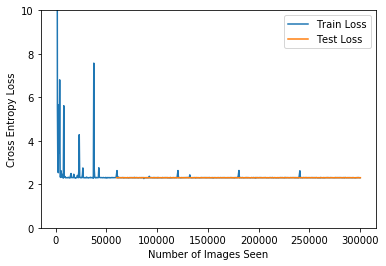

Final Test Cross Entropy Loss: 2.3037855412550035. Final Test accuracy: 0.1135


In [8]:

# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss")
utils.plot_loss(val_loss_dict, label="Test Loss")
# plt.ylim([0, 1])
plt.ylim([0, 10])
plt.legend()
plt.xlabel("Number of Images Seen")
plt.ylabel("Cross Entropy Loss")
plt.savefig("new_learning_hidden_training_loss.png")

plt.show()
torch.save(model.state_dict(), "new_learning_hidden_saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_val, model, loss_function)
print(f"Final Test Cross Entropy Loss: {final_loss}. Final Test accuracy: {final_acc}")

# Plot loss
# utils.plot_loss(normalized_train_loss_dict, label="Train Loss")
# utils.plot_loss(normalized_val_loss_dict, label="Test Loss")
# plt.ylim([0, 1])
# plt.legend()
# plt.xlabel("Number of Images Seen")
# plt.ylabel("Cross Entropy Loss")
# plt.savefig("normalized_training_loss.png")

# plt.show()
# torch.save(model.state_dict(), "normalized_saved_model.torch")
# final_loss, final_acc = utils.compute_loss_and_accuracy(
#     normalized_dataloader_val, model, loss_function)
# print(f"Final Test Cross Entropy Loss: {final_loss}. Final Test accuracy: {final_acc}")

In [9]:
print(max(val_loss_dict), min(val_loss_dict))
print(max(train_loss_dict), min(train_loss_dict))

300160 60032
299712 448
